(bayesian_workflow)=

# The Bayesian Workflow: COVID-19 Outbreak Modeling

:::{post} Jun 16, 2025
:tags: workflow
:category: intermediate, how-to
:author: Thomas Wiecki, Chris Fonnesbeck
:::

Bayesian modeling is a robust approach for drawing conclusions from data. Successful modeling involves an interplay among statistical models, subject matter knowledge, and computational techniques. In building Bayesian models, it is easy to get carried away with complex models from the outset, often leading to an unsatisfactory final result (or a dead end). To avoid common model development pitfalls, a structured approach is helpful. The *Bayesian workflow* (Gelman *et al.*) is a systematic approach to building, validating, and refining probabilistic models, ensuring that the models are robust, interpretable, and useful for decision-making. The workflow's iterative nature ensures that modeling assumptions are tested and refined as the model grows, leading to more reliable results.

This workflow is particularly powerful in high-level probabilistic programming environments like PyMC, where the ability to rapidly prototype and iterate on complex statistical models enables practitioners to focus on the modeling process rather than the underlying computational details. The workflow invlolves moving from simple models--via prior checks, fitting, diagnostics, and refinement--through to a final product that satisfies the analytic goals, making sure that computational and conceptual issues are identified and addressed systematically as they are encountered.

Below we demonstrate the Bayesian workflow using COVID-19 case data, showing how to progress from very basic, unrealistic models to more sophisticated formulations, highlighting the critical role of model checking and validation at each step. Here we are not looking to develop a state-of-the-art epidemiological model, but rather to demonstrate how to iterate from a simple model to a more complex one.

In [1]:
import warnings

import arviz.preview as az
import load_covid_data
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import polars as pl
import preliz as pz
import pymc as pm

from plotly.subplots import make_subplots

# Set renderer to generate static images
pio.renderers.default = "png"
pio.defaults.default_width = 1000
pio.defaults.default_height = 300

RANDOM_SEED = 8451997
sampler_kwargs = {"chains": 4, "cores": 4, "tune": 1000, "random_seed": RANDOM_SEED}


az.rcParams["plot.backend"] = "plotly"
az.style.use("arviz-variat")

colors = pio.templates["arviz-variat"].layout.colorway

Bayesian methods offer several fundamental strengths that make it particularly valuable for building robust statistical models. Its great **flexibility** allows practitioners to build remarkably complex models from simple building blocks. The framework provides a principled way of dealing with **uncertainty**, capturing not just the most likely outcome but the complete distribution of all possible outcomes. Critically, Bayesian methods allow **expert information** to guide model development through the use of informative priors, incorporating domain knowledge directly into the analysis.

In this section you'll learn:
* How to go from data to a model idea
* How to find priors for your model
* How to evaluate a model
* How to iteratively improve a model
* How to forecast into the future
* How powerful generative modeling can be

## The Bayesian Workflow: An Overview

Before diving into our COVID-19 modeling example, let's understand the key stages of the Bayesian workflow as outlined by Gelman et al. (2020). This workflow is not a linear process but rather an iterative cycle where we continuously refine our understanding.

:::{admonition} The Bayesian Workflow Stages
:class: tip

1. **Conceptual model building**: Translate domain knowledge into statistical assumptions
2. **Prior predictive simulation**: Check if priors generate reasonable data
3. **Computational implementation**: Code the model and ensure it runs
4. **Fitting and diagnostics**: Estimate parameters and check convergence
5. **Model evaluation**: Assess model fit using posterior predictive checks
6. **Model comparison**: Compare alternative models systematically
7. **Model expansion or simplification**: Iterate based on findings
8. **Decision analysis**: Use the model for predictions or decisions
:::

Throughout this tutorial, we'll explicitly mark which stage of the workflow we're in, helping you understand not just *what* we're doing, but *why* we're doing it.

## Load and Explore Data

:::{admonition} Workflow Stage: Conceptual Model Building
:class: note

We begin by understanding our data and its context. This exploratory phase informs our initial modeling decisions.
:::

First we'll load data on COVID-19 cases from the World Health Organization (WHO). In order simplify the analysis we will restrict the dataset to the time after 100 cases were confirmed (as reporting is often very noisy prior to that). It also allows us to align countries with each other for easier comparison.

In [2]:
df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.select("country").unique().to_series().to_list()
n_countries = len(countries)
df = df.filter(pl.col("days_since_100") >= 0)
df.head()

country,state,date,confirmed,type,critical_estimate,days_since_100,deaths
str,str,date,i64,str,f64,i64,i64
"""Diamond Princess""",null,2020-02-10,135,"""confirmed""",6.75,0,0
"""Diamond Princess""",null,2020-02-11,135,"""confirmed""",6.75,1,0
"""Diamond Princess""",null,2020-02-12,175,"""confirmed""",8.75,2,0
"""Diamond Princess""",null,2020-02-13,175,"""confirmed""",8.75,3,0
"""Diamond Princess""",null,2020-02-14,218,"""confirmed""",10.9,4,0


## Bayesian Workflow

Next, we will start developing a model of the spread. These models will start out simple (and poor) but we will iteratively improve them. A good workflow to adopt when developing your own models is:

1. **Plot the data** - Understand patterns and features
2. **Build model** - Start simple, add complexity gradually
3. **Run prior predictive check** - Ensure priors generate sensible data
4. **Fit model** - Estimate parameters from data
5. **Assess convergence** - Verify computational reliability
6. **Check model fit** - Compare predictions to observations
7. **Improve model** - Address identified deficiencies

### 1. Plot the data

We will look at German COVID-19 cases. At first, we will only look at the first 30 days after Germany crossed 100 cases, later we will look at the full data.

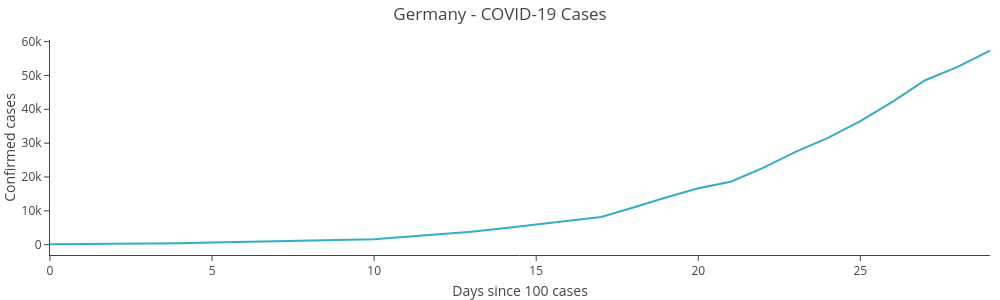

In [3]:
from datetime import datetime

country = "Germany"
date = datetime.strptime("2020-07-31", "%Y-%m-%d").date()
df_country = df.filter(pl.col("country") == country).filter(pl.col("date") <= date).head(30)

fig = px.line(
    df_country.to_pandas(),
    x="days_since_100",
    y="confirmed",
    title=f"{country} - COVID-19 Cases",
    labels={"days_since_100": "Days since 100 cases", "confirmed": "Confirmed cases"},
)
fig.show()

Look at the above plot and think about what type of model you would build to capture this pattern. What mathematical function might describe this growth?

### Step 2: Build Models - Starting with a Baseline

:::{admonition} Workflow Stage: Model Building
:class: note

Before jumping to complex models, we establish a baseline. This helps us understand how much we gain from added complexity.
:::

#### A Baseline Model

A critical but often overlooked step is establishing a baseline model. This gives us a reference point to judge whether our more complex models are actually capturing meaningful patterns.

The trajectory of cumulative cases kind of looks exponential. This matches with knowledge from epidemiology whereas early in an epidemic it grows exponentially.

In [4]:
# Get time-range of days since 100 cases were crossed
t = df_country.select("days_since_100").to_numpy().flatten()
# Get number of confirmed cases for Germany
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp1:
    # Intercept
    a = pm.Normal("a", mu=0, sigma=100)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal("eps", 100)

    # Likelihood
    pm.Normal("obs", mu=growth, sigma=eps, observed=confirmed)

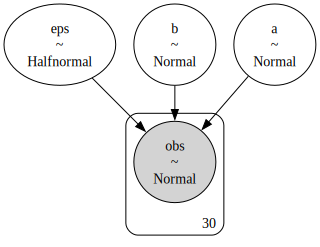

In [5]:
pm.model_to_graphviz(model_exp1)

:::{admonition} Model Critique
:class: tip

Before fitting, consider: What assumptions does this model make? Are there any issues you can identify just from the model specification? Is there anything you would have done differently?
:::


### Step 3: Run Prior Predictive Check

:::{admonition} Workflow Stage: Prior Predictive Simulation
:class: note

Before fitting, we check if our priors generate reasonable data. This is a crucial but often skipped step!
:::

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intuition about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

The process works as follows:

1. Pick a point from the prior $\theta_i$
2. Generate data set $x_i \sim f(\theta_i)$ where $f$ is our likelihood function (e.g. normal)
3. Rinse and repeat $n$ times

In [6]:
with model_exp1:
    prior_pred = pm.sample_prior_predictive()

Sampling: [a, b, eps, obs]


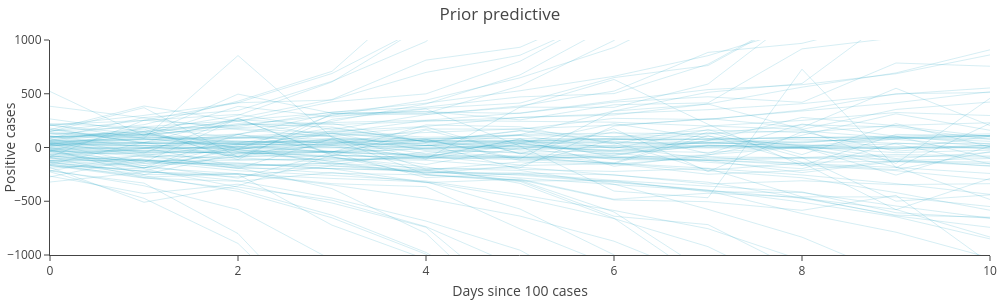

In [7]:
prior_obs = prior_pred.prior_predictive["obs"].values.squeeze().T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[-1000, 1000]),
    xaxis=dict(range=[0, 10]),
)

:::{admonition} What's Wrong With This Model?
:class: warning

Our prior predictive check reveals several problems:
1. **Negative cases**: Impossible in reality
2. **Starting near zero**: We conditioned on 100+ cases
3. **Normal likelihood**: Allows negative values and symmetric errors

This demonstrates the value of prior predictive checking!
:::



Let's improve our model. The presence of negative cases is due to us using a Normal likelihood. Instead, let's use a `NegativeBinomial`, which is similar to `Poisson` which is commonly used for count-data but has an extra dispersion parameter that allows more flexiblity in modeling the variance of the data.

We will also change the prior of the intercept to be centered at 100 and tighten the prior of the slope.

The negative binomial distribution uses an overdispersion parameter, which we will describe using a gamma distribution. A companion package called `preliz`, a library for prior distribution elicitation, has a nice utility called `maxent` that will help us parameterize this prior, as the gamma distribution is not as intuitive to work with as the normal distribution.

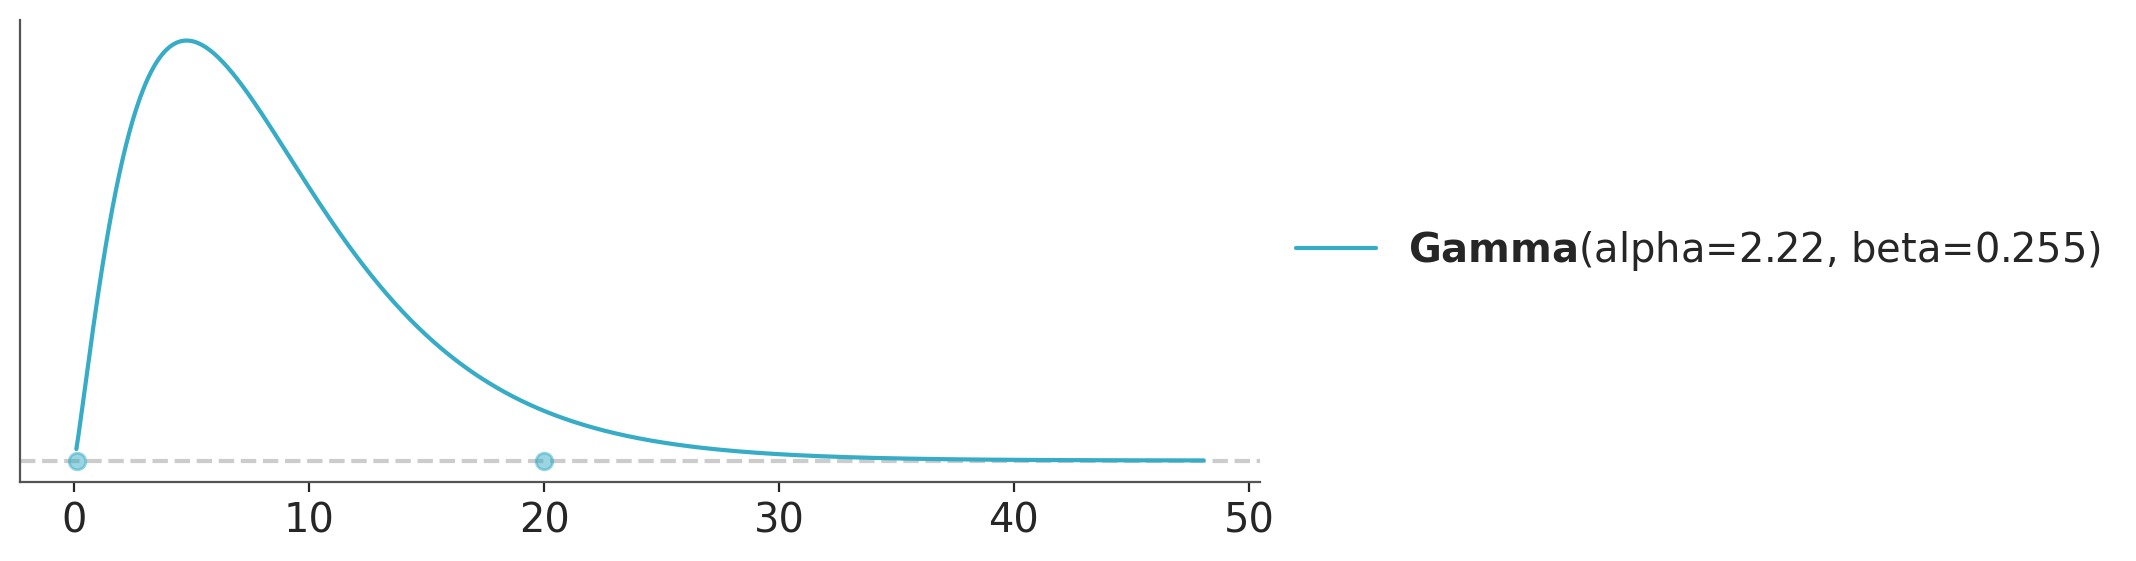

In [8]:
dist = pz.Gamma()

pz.maxent(dist, lower=0.1, upper=20, mass=0.95, plot_kwargs={"figsize": (8, 3)});

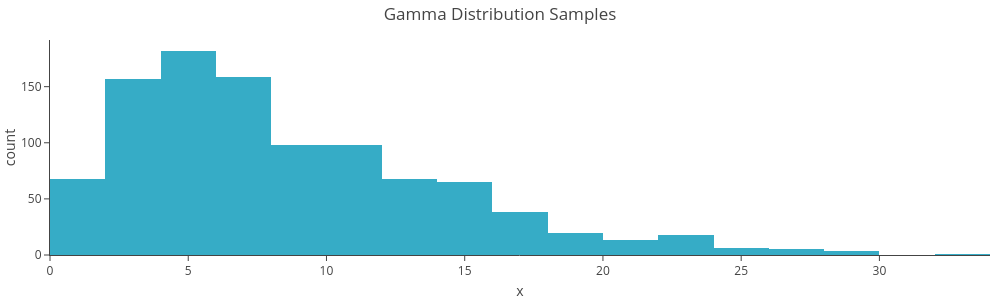

In [9]:
px.histogram(x=dist.rvs(1000), nbins=20, title="Gamma Distribution Samples")

In [10]:
t = df_country.select("days_since_100").to_numpy().flatten()
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp2:
    # Intercept
    a = pm.Normal("a", mu=100, sigma=25)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    alpha = alpha = dist.to_pymc("alpha")

    # Likelihood
    pm.NegativeBinomial("obs", growth, alpha=alpha, observed=confirmed)

Sampling: [a, alpha, b, obs]


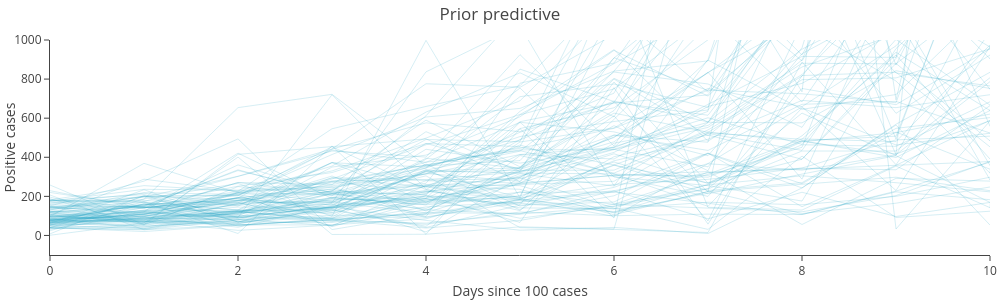

In [11]:
with model_exp2:
    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

prior_obs = prior_pred.prior_predictive["obs"].values.squeeze().T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[-100, 1000]),
    xaxis=dict(range=[0, 10]),
)

:::{admonition} Progress!
:class: success

Much better! No negative cases, and the scale looks more reasonable. But we can still incorporate more domain knowledge.
:::

#### Model 3: Incorporating Domain Constraints

We know that:
- The intercept *cannot* be below 100 (by construction of our data)
- The growth rate must be positive

Let's encode this knowledge: we use the PyMC `HalfNormal` distribution for the intercept prior; we can apply the same for the slope which we know is not going to be negative.

In [12]:
t = df_country.select("days_since_100").to_numpy().flatten()
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp3:
    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    a = pm.Deterministic("a", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Overdispersion parameter
    alpha = pz.maxent(pz.Gamma(), lower=0.1, upper=20, mass=0.95, plot=False).to_pymc("alpha")

    # Likelihood
    pm.NegativeBinomial("obs", growth, alpha=alpha, observed=confirmed)

    prior_pred3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [a0, alpha, b, obs]


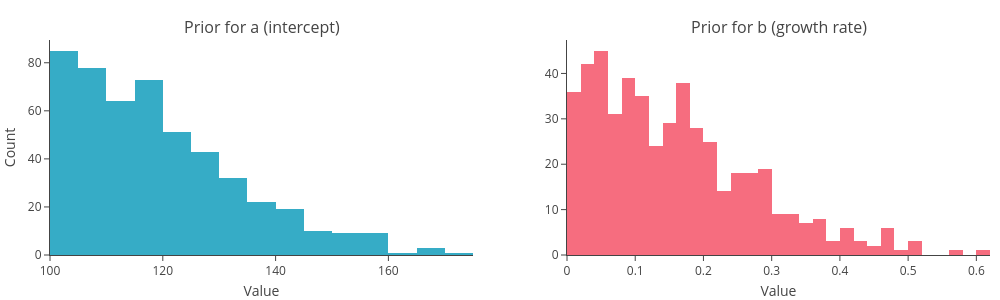

In [13]:
make_subplots(
    rows=1, cols=2, subplot_titles=("Prior for a (intercept)", "Prior for b (growth rate)")
).add_trace(
    go.Histogram(x=prior_pred3.prior["a"].values.flatten(), nbinsx=30, name="a"), row=1, col=1
).add_trace(
    go.Histogram(x=prior_pred3.prior["b"].values.flatten(), nbinsx=30, name="b"), row=1, col=2
).update_xaxes(
    title_text="Value", row=1, col=1
).update_xaxes(
    title_text="Value", row=1, col=2
).update_yaxes(
    title_text="Count", row=1, col=1
).update_layout(
    showlegend=False, height=350
)

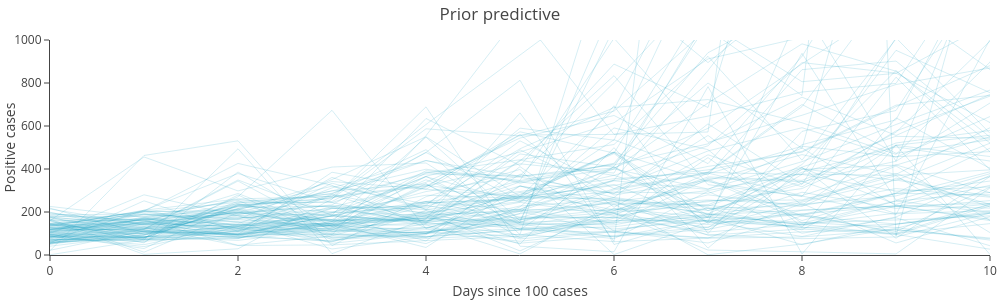

In [14]:
obs_samples = az.extract(prior_pred3.prior_predictive).values

fig = go.Figure()
for i in range(min(100, obs_samples.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(obs_samples[:, i]))),
            y=obs_samples[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[0, 1000]),
    xaxis=dict(range=[0, 10]),
)

Note that even though the intercept parameter can not be below 100 now, we still see data generated at below hundred. Why? 

### Step 4: Fit Model

:::{admonition} Workflow Stage: Model Fitting
:class: note

Now we fit our model using MCMC. This is where the "Inference Button™" (`pm.sample`) comes in!
:::

In [15]:
with model_exp3:
    trace_exp3 = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Step 5: Assess Convergence

:::{admonition} Workflow Stage: Computational Diagnostics
:class: note

Before trusting our results, we must verify that the sampler has converged properly.
:::

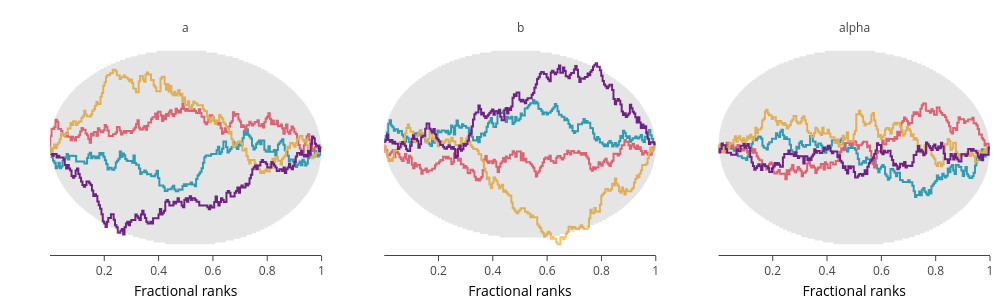

In [16]:
az.plot_rank(trace_exp3, var_names=["a", "b", "alpha"]).show()

In [17]:
az.summary(trace_exp3, var_names=["a", "b", "alpha"], kind="diagnostics")

,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
a,1405.91,1762.68,1.0,0.35,0.25
b,1454.45,1829.90,1.0,0.00,0.00
alpha,1934.21,1921.74,1.0,0.09,0.07


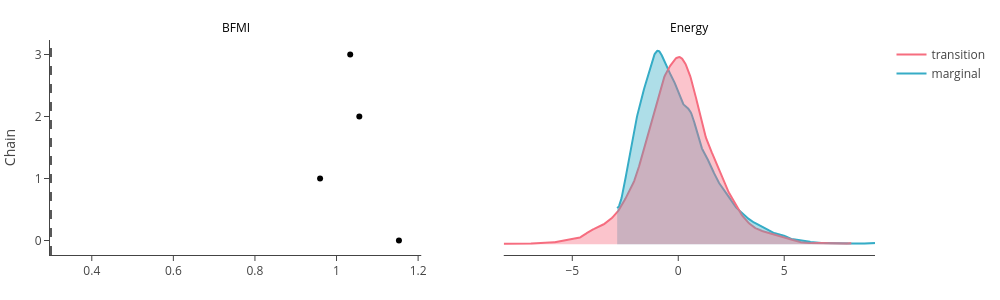

In [18]:
pc = az.plot_energy(trace_exp3).show()

:::{admonition} Convergence Checklist
:class: success

✓ **R-hat values**: All close to 1.0 (< 1.01)  
✓ **Effective sample size**: Reasonable for all parameters  
✓ **Rank plots**: Show relatively good mixing with no trends  
✓ **Energy plot**: Marginal and energy distributions overlap well  

Our model has converged successfully!
:::

### Model comparison

Let's quickly compare the two models we were able to sample from.

Model comparison requires the log-likelihoods of the respective models. For efficiency, these are not computed automatically, so we need to manually calculate them.

In [19]:
with model_exp2:
    trace_exp2 = pm.sample(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

with model_exp3:
    pm.compute_log_likelihood(trace_exp3)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Output()

Now we can use the ArviZ `compare` function:

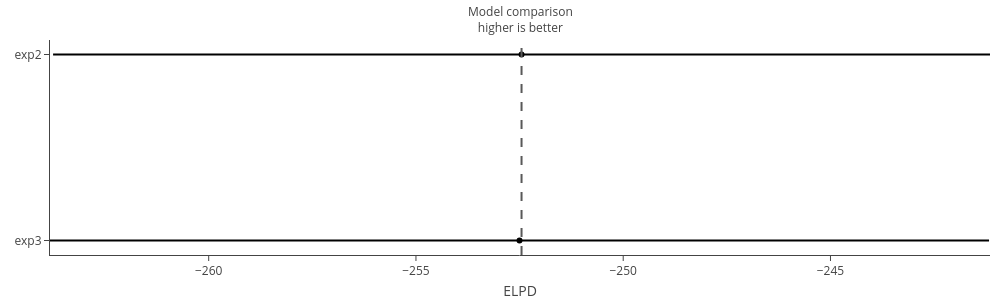

In [20]:
comparison = az.compare({"exp2": trace_exp2, "exp3": trace_exp3})
az.plot_compare(comparison).show()

It seems like bounding the priors did not result in better fit. This is not unexpected because our change in prior was very small. We will still continue with `model_exp3` because we have prior information that these parameters are bounded in this way.

### Sensitivity Analysis

:::{admonition} Workflow Stage: Model Criticism
:class: note

A crucial but often neglected step is understanding how sensitive our conclusions are to modeling choices.
:::

Let's examine how our results change with different prior choices:

In [21]:
# Fit model with different priors
prior_configs = [
    {"name": "Tight priors", "b_sigma": 0.01},
    {"name": "Original priors", "b_sigma": 0.2},
    {"name": "Loose priors", "b_sigma": 1},
]

results = {}

for config in prior_configs:
    with pm.Model() as model_sensitivity:

        t_sens = df_country.select("days_since_100").to_numpy().flatten()
        confirmed_sens = df_country.select("confirmed").to_numpy().flatten()

        a0 = pm.HalfNormal("a0", sigma=25)
        a = pm.Deterministic("a", a0 + 100)
        b = pm.HalfNormal("b", sigma=config["b_sigma"])  # Varying prior

        growth = a * (1 + b) ** t_sens

        pm.NegativeBinomial(
            "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_sens
        )

        trace = pm.sample(
            chains=2, draws=1000, tune=1000, random_seed=RANDOM_SEED, progressbar=False
        )
        results[config["name"]] = trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, b, alpha]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, b, alpha]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, b, alpha]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chai

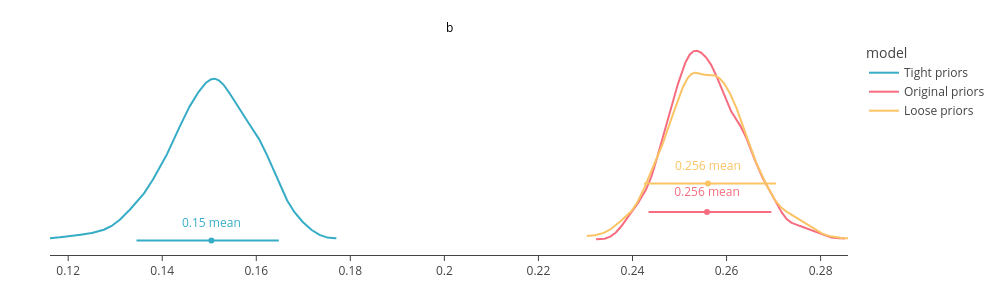

In [22]:
pc = az.plot_dist(results, var_names=["b"])
pc.add_legend("model")
pc.show()

:::{admonition} Sensitivity Analysis Results
:class: note

The posterior is relatively robust to prior choice when we have sufficient data. However, with limited data (early in the outbreak), prior choice matters more. This highlights the importance of:
1. Using domain knowledge to set reasonable priors
2. Checking sensitivity when data is limited
3. Being transparent about prior choices
:::

### Step 6: Check Model Fit

:::{admonition} Workflow Stage: Model Evaluation
:class: note

Posterior predictive checking is crucial for understanding how well our model captures the data-generating process.
:::

Similar to the prior predictive, we can also generate new data by repeatedly taking samples from the posterior and generating data using these parameters. This process is called **posterior predictive checking** and is a crucial step in Bayesian model validation.

Posterior predictive checking works by:
1. Taking parameter samples from the posterior distribution (which we already have from MCMC sampling)
2. For each set of parameter values, generating new synthetic datasets using the same likelihood function as our model
3. Comparing these synthetic datasets to our observed data

This allows us to assess whether our model can reproduce key features of the observed data. If the posterior predictive samples look very different from our actual data, it suggests our model may be missing important aspects of the data-generating process. Conversely, if the posterior predictive samples encompass our observed data well, it provides evidence that our model is capturing the essential patterns in the data.

In [23]:
with model_exp3:
    post_pred = pm.sample_posterior_predictive(trace_exp3.posterior, random_seed=RANDOM_SEED)

Sampling: [obs]


Output()

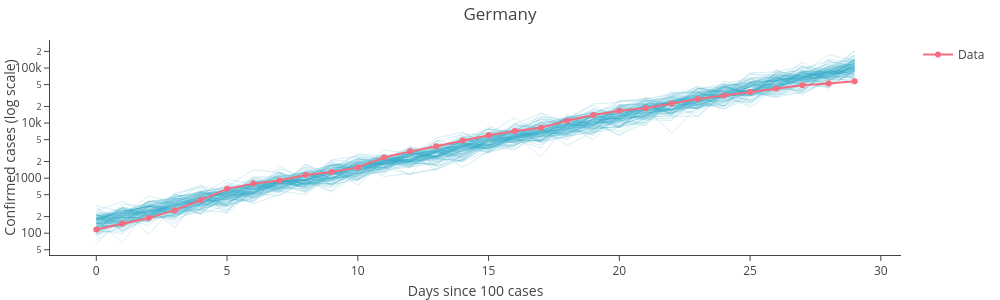

In [24]:
post_pred_samples = post_pred.posterior_predictive["obs"].sel(chain=0).values.squeeze().T
confirmed_values = confirmed

fig = go.Figure()

for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.add_trace(
    go.Scatter(
        x=list(range(len(confirmed_values))),
        y=confirmed_values,
        mode="lines+markers",
        line=dict(color=colors[1], width=2),
        name="Data",
    )
).update_layout(
    title=country,
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases (log scale)",
    yaxis_type="log",
)

OK, that does not look terrible; the data essentially behaves like a random draw from the model.

As an additional check, we can also inspect the model residuals.

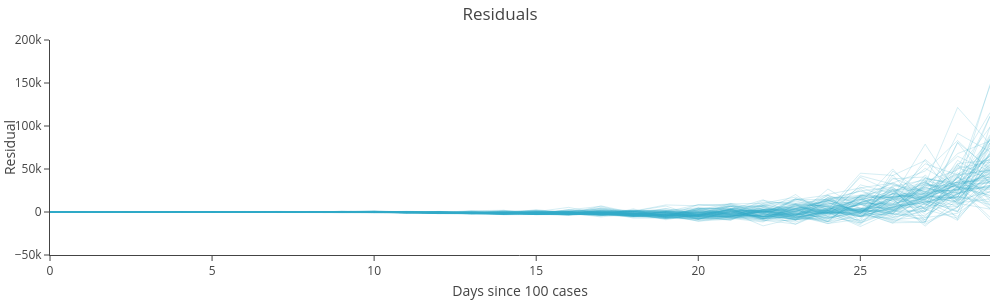

In [25]:
resid = post_pred.posterior_predictive["obs"].sel(chain=0) - confirmed_values
resid_values = resid.values.T

fig = go.Figure()

for i in range(min(100, resid_values.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(resid_values[:, i]))),
            y=resid_values[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Residuals",
    xaxis_title="Days since 100 cases",
    yaxis_title="Residual",
    yaxis=dict(range=[-50000, 200000]),
)

:::{admonition} Residual Analysis
:class: warning

Notice the systematic pattern in residuals - there is a bias that tends to increase over time. This suggests our exponential model may be too rigid for longer time periods.
:::

### Prediction and forecasting

:::{admonition} Workflow Stage: Decision Analysis
:class: note

Models are often built for prediction. Let's see how our model performs on out-of-sample data.
:::

We are often interested in predicting or forecasting. In PyMC, you can do so easily using `pm.Data` nodes, which provide a powerful mechanism for out-of-sample prediction and forecasting.

Wrapping your input data in `pm.Data` allows you to define data containers within a PyMC model that can be dynamically updated after model fitting. This is particularly useful for prediction scenarios where you want to:

1. **Train on observed data**: Fit your model using the available training data
2. **Switch to prediction inputs**: Replace the training data with new input values (e.g., future time points)
3. **Generate predictions**: Use posterior predictive sampling to generate forecasts based on the fitted model

Let's demonstrate this approach by modifying our exponential growth model to use `pm.Data` nodes.

In [26]:
with pm.Model() as model_exp4:
    t_data = pm.Data("t", df_country.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_country.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    a = pm.Deterministic("a", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    # Exponential regression
    growth = a * (1 + b) ** t_data

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

    trace_exp4 = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [27]:
with model_exp4:
    # Update our data containers.
    # Recall that because confirmed is observed, we do not
    # need to specify any data, as that is only needed
    # during inference. But do have to update it to match
    # the shape.
    pm.set_data({"t": np.arange(60), "confirmed": np.zeros(60, dtype="int")})

    post_pred_forecast = pm.sample_posterior_predictive(
        trace_exp4.posterior, random_seed=RANDOM_SEED
    )

Sampling: [obs]


Output()

As we held data back before, we can now see how the predictions of the model

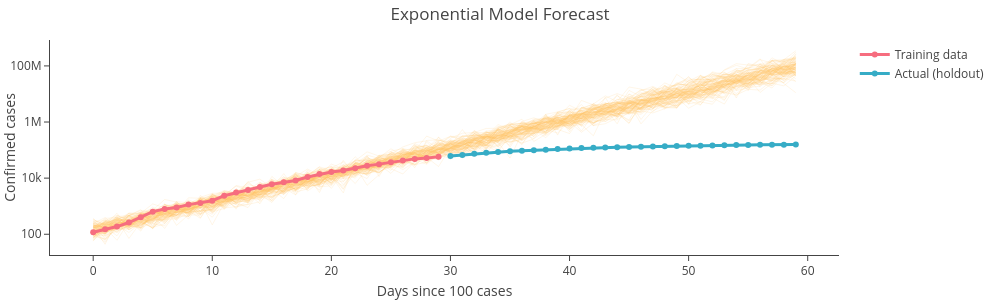

In [28]:
df_full = df.filter(pl.col("country") == country).filter(pl.col("date") <= date)
full_confirmed = df_full.select("confirmed").to_numpy().flatten()

post_pred_samples = post_pred_forecast.posterior_predictive["obs"].sel(chain=0).squeeze().values.T

fig = go.Figure()

for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(60)),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color=colors[2], width=0.5),
            opacity=0.3,
            showlegend=False,
        )
    )

fig.add_trace(
    go.Scatter(
        x=list(range(30)),
        y=confirmed,
        mode="lines+markers",
        line=dict(color=colors[1], width=3),
        marker=dict(size=6),
        name="Training data",
    )
)

if len(full_confirmed) > 30:
    fig.add_trace(
        go.Scatter(
            x=list(range(30, min(60, len(full_confirmed)))),
            y=full_confirmed[30:60],
            mode="lines+markers",
            line=dict(color=colors[0], width=3),
            marker=dict(size=6),
            name="Actual (holdout)",
        )
    )

fig.update_layout(
    title="Exponential Model Forecast",
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases",
    yaxis_type="log",
    height=400,
)

:::{admonition} Forecast Performance
:class: warning

The exponential model severely overestimates future cases. This is a common issue with exponential growth models - they don't account for the natural limits on disease spread.
:::

### Step 7: Improve Model - Logistic Growth

:::{admonition} Workflow Stage: Model Expansion
:class: note

Based on our findings, we need a model that can capture slowing growth. The logistic model is a natural choice.
:::

The logistic model incorporates a "carrying capacity" - a maximum number of cases that limits growth:

$$\text{cases}(t) = \frac{K}{1 + A e^{-rt}}$$

where $K$ is the carrying capacity, $r$ is the growth rate, and $A$ determines the curve's midpoint.

### Logistic model

<img src="https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/924/2015/11/25202016/CNX_Precalc_Figure_04_07_0062.jpg"/>

In [29]:
df_country = df.filter(pl.col("country") == country).filter(pl.col("date") <= date)

with pm.Model() as logistic_model:
    t_data = pm.Data("t", df_country.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_country.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    intercept = pm.Deterministic("intercept", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    carrying_capacity = pm.Uniform("carrying_capacity", lower=1_000, upper=80_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

    prior_pred_logistic = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [a0, alpha, b, carrying_capacity, obs]


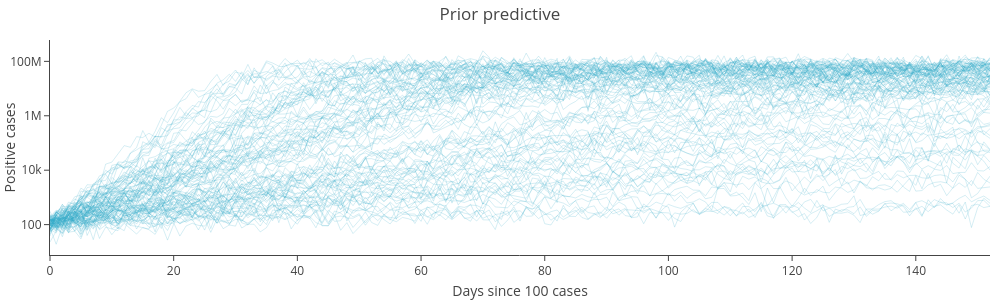

In [30]:
prior_obs = prior_pred_logistic.prior_predictive["obs"].squeeze().values.T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis_type="log",
)

In [31]:
with logistic_model:
    # Inference
    trace_logistic = pm.sample(**sampler_kwargs, target_accept=0.9)

    # Sample posterior predcitive
    pm.sample_posterior_predictive(trace_logistic, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, carrying_capacity, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [obs]


Output()

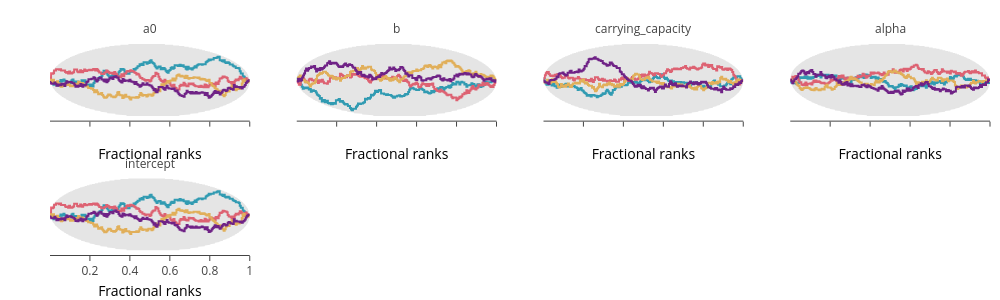

In [32]:
az.plot_rank(trace_logistic).show()

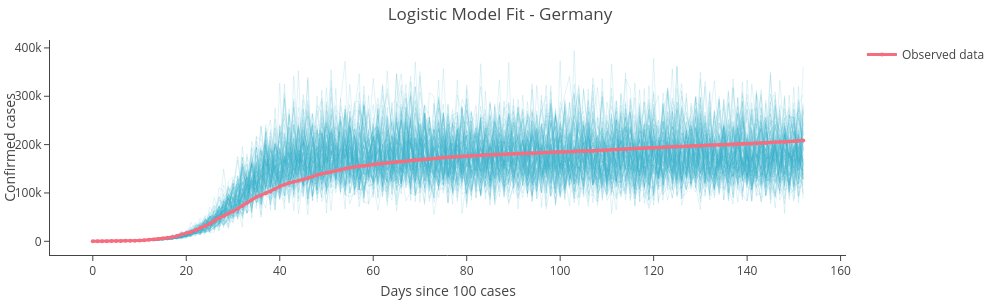

In [33]:
full_confirmed = (
    df.filter(pl.col("country") == country)
    .filter(pl.col("date") <= date)
    .select("confirmed")
    .to_numpy()
    .flatten()
)
post_pred_samples = trace_logistic.posterior_predictive["obs"].sel(chain=0).squeeze().values.T

fig = go.Figure()

for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.3,
            showlegend=False,
        )
    )

fig.add_trace(
    go.Scatter(
        x=list(range(len(full_confirmed))),
        y=full_confirmed,
        mode="lines+markers",
        line=dict(color=colors[1], width=3),
        marker=dict(size=4),
        name="Observed data",
    )
).update_layout(
    title="Logistic Model Fit - Germany",
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases",
    height=400,
)

:::{admonition} Improved Fit!
:class: success

The logistic model captures the slowing growth much better than the exponential model. The carrying capacity parameter allows the model to naturally plateau.
:::

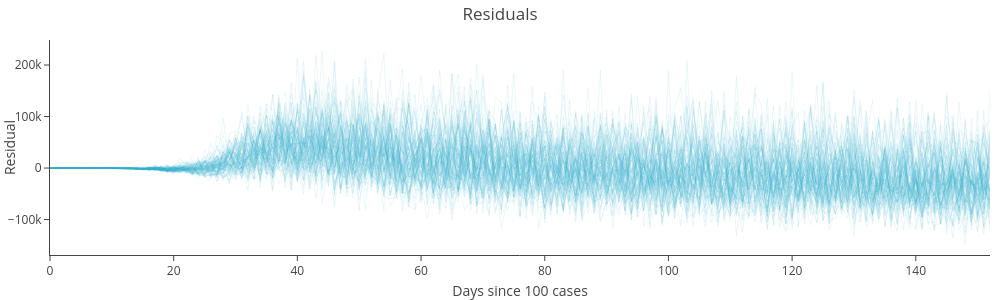

In [34]:
resid = trace_logistic.posterior_predictive["obs"].sel(chain=0).squeeze().values - full_confirmed
resid_values = resid.T

fig = go.Figure()

for i in range(min(100, resid_values.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(resid_values[:, i]))),
            y=resid_values[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.2,
            showlegend=False,
        )
    )

fig.update_layout(title="Residuals", xaxis_title="Days since 100 cases", yaxis_title="Residual")

What is the difference between the residuals from before?

#### Model comparison

In order to compare our models we first need to refit with the longer data we now have. Fortunately we can easily swap out the data because these are `pm.Data` now.

In [35]:
with model_exp4:
    pm.set_data(
        {
            "t": df_country.select("days_since_100").to_numpy().flatten(),
            "confirmed": df_country.select("confirmed").to_numpy().flatten(),
        }
    )

    trace_exp4_full = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [36]:
with model_exp4:
    pm.compute_log_likelihood(trace_exp4_full)

with logistic_model:
    pm.compute_log_likelihood(trace_logistic)

az.plot_compare(az.compare({"exp4": trace_exp4_full, "logistic": trace_logistic}));

Output()

Output()

As you can see, the logistic model provides a much better fit to the data. 

### Model Validation: Testing on Another Country

:::{admonition} Workflow Stage: Model Criticism
:class: note

A key test of our model is whether it generalizes to other contexts. Let's try the US data.
:::

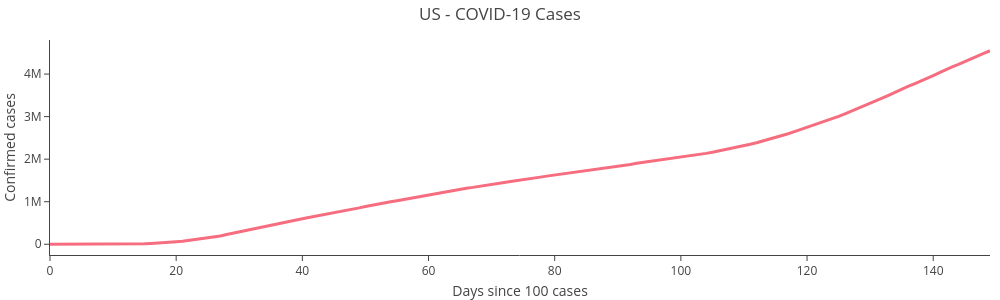

In [37]:
country = "US"
df_us = df.filter(pl.col("country") == country).filter(pl.col("date") <= date)

fig = px.line(
    df_us.to_pandas(),
    x="days_since_100",
    y="confirmed",
    title=f"{country} - COVID-19 Cases",
    labels={"days_since_100": "Days since 100 cases", "confirmed": "Confirmed cases"},
)
fig.update_traces(line=dict(color=colors[1], width=3))
fig.update_layout(height=400)

The US data looks quite different - there appear to be multiple waves. Let's see how our logistic model handles this:

In [38]:
with pm.Model() as logistic_model_us:
    t_data = pm.Data("t", df_us.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_us.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    intercept = pm.Deterministic("intercept", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    carrying_capacity = pm.Uniform("carrying_capacity", lower=1_000, upper=100_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

In [39]:
with logistic_model_us:
    trace_logistic_us = pm.sample(**sampler_kwargs)
    pm.sample_posterior_predictive(
        trace_logistic_us, extend_inferencedata=True, random_seed=RANDOM_SEED
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, carrying_capacity, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [obs]


Output()

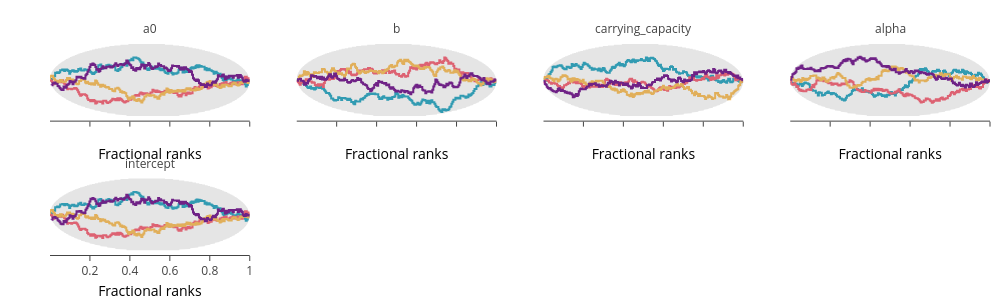

In [40]:
az.plot_rank(trace_logistic_us).show()

Sampling: [obs]


Output()

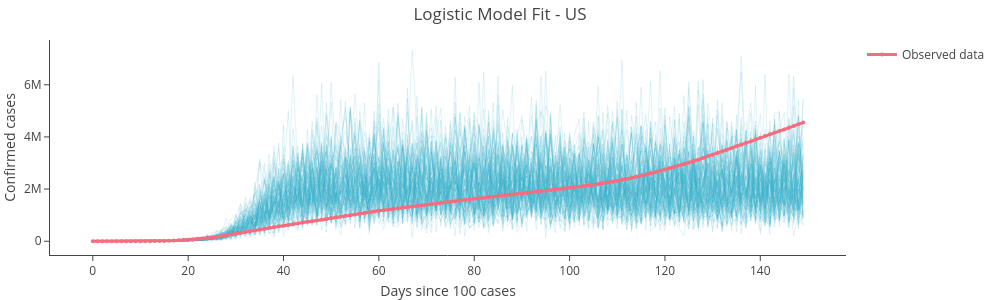

In [41]:
with logistic_model_us:
    pm.sample_posterior_predictive(
        trace_logistic_us, extend_inferencedata=True, random_seed=RANDOM_SEED
    )

us_confirmed = df_us.select("confirmed").to_numpy().flatten()
post_pred_samples = trace_logistic_us.posterior_predictive["obs"].sel(chain=0).squeeze().values.T

fig = go.Figure()

# Add posterior predictive samples
for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color=colors[0], width=0.5),
            opacity=0.3,
            showlegend=False,
        )
    )

fig.add_trace(
    go.Scatter(
        x=list(range(len(us_confirmed))),
        y=us_confirmed,
        mode="lines+markers",
        line=dict(color=colors[1], width=3),
        marker=dict(size=4),
        name="Observed data",
    )
).update_layout(
    title="Logistic Model Fit - US",
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases",
    height=400,
)

:::{admonition} Model Limitations Revealed
:class: warning

The simple logistic model fails to capture the multiple waves in US data. This reveals important limitations:
1. Single logistic curves assume one continuous outbreak
2. Real epidemics have multiple waves due to policy changes, new variants, etc.
3. Different countries have different dynamics

This motivates additional model improvement!
:::

## Exercises for Further Exploration

1. **Time-Varying Parameters**: Extend the logistic model to allow the growth rate to change over time (hint: use changepoint models)

2. **External Covariates**: Add policy intervention dates as covariates to model their effect on transmission

3. **Model Averaging**: Instead of selecting one model, try Bayesian model averaging

4. **Predictive Validation**: Hold out the last 30 days of data and evaluate forecast accuracy

5. **Prior Elicitation**: Interview a domain expert and encode their knowledge as priors

## References

Gelman, A., Vehtari, A., Simpson, D., Margossian, C. C., Carpenter, B., Yao, Y., ... & Modrák, M. (2020). Bayesian workflow. *arXiv preprint arXiv:2011.01808*.

## Authors
- Originally authored by Thomas Wiecki in 2020
- Adapted and expanded by Chris Fonnesbeck in June 2025 

## Watermark

In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Dec 15 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

plotly: 6.2.0
arviz : 0.23.0.dev0
pymc  : 5.26.1
numpy : 2.2.6
preliz: 0.21.0
polars: 1.30.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::